In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#work path
#path = 'C:\\Users\\e057074\\Documents\\Other\\Grad School\\DS-GA 1001\\Project\\'

#mac path
path = '/Users/Lisa/Documents/Fall 2016/DS-GA 1001/Project/'

ps_north = pd.read_csv(path + 'per_station/519.csv')
print('Length:', len(ps_north))
print(ps_north.columns)
ps_north['last_reported'] = pd.to_datetime(ps_north['last_reported'], infer_datetime_format=True)
ps_north['weather_ts'] = pd.to_datetime(ps_north['weather_ts'], unit='s')
ps_north['traffic_0_asof'] = pd.to_datetime(ps_north['traffic_0_asof'], infer_datetime_format=True)
ps_north['traffic_1_asof'] = pd.to_datetime(ps_north['traffic_1_asof'], infer_datetime_format=True)
ps_north['traffic_2_asof'] = pd.to_datetime(ps_north['traffic_2_asof'], infer_datetime_format=True)



Length: 4789
Index(['Unnamed: 0', 'eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time', 'y_10m',
       'y_15m', 'y_30m', 'y_45m', 'y_60m', 'y_90m', 'y_120m'

In [3]:
#drop obs w stale traffic data
ps_north['delta_t0'] = (ps_north['traffic_0_asof'] - ps_north['last_reported'])/np.timedelta64(1,'m')
ps_north['delta_t1'] = (ps_north['traffic_1_asof'] - ps_north['last_reported'])/np.timedelta64(1,'m')
ps_north['delta_t2'] = (ps_north['traffic_2_asof'] - ps_north['last_reported'])/np.timedelta64(1,'m')
ps_north['nonstale'] = (ps_north['delta_t0'] > -15) & (ps_north['delta_t1'] > -15) & (ps_north['delta_t2'] > -15)

nonstale = ps_north[ps_north['nonstale'] == True]

#drop rows with no value within the 60m target variable period
y60 = nonstale[nonstale['y_60m'] >= 0]

In [5]:
#create labels. -1 = empty, 0 = available, 1 = full
y60.loc[:,'target_60'] = 0
y60.loc[y60['y_60m']<= 0.05,'target_60'] = -1
y60.loc[y60['y_60m']>= 0.95,'target_60'] = 1

/Users/Lisa/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
#Distribution of class variables
y60.groupby(['target_60']).agg('count')

,Unnamed: 0,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,...,y_15m,y_30m,y_45m,y_60m,y_90m,y_120m,delta_t0,delta_t1,delta_t2,nonstale
target_60,,,,,,,,,,,,,,,,,,,,,
-1,605,605,605,605,605,605,605,605,605,605,...,605,605,605,605,605,605,605,605,605,605
0,1806,1806,1806,1806,1806,1806,1806,1806,1806,1806,...,1806,1806,1806,1806,1806,1806,1806,1806,1806,1806
1,139,139,139,139,139,139,139,139,139,139,...,139,139,139,139,139,139,139,139,139,139


In [19]:
#Drop variables not used in first prelim model
y60 = y60[['last_reported','num_bikes_available','num_docks_available','num_bikes_disabled','num_docks_disabled',\
                    'is_installed','is_renting','is_returning','apparentTemperature','precipType','summary','traffic_0_speed',\
                    'traffic_0_distance','traffic_1_speed','traffic_1_distance','traffic_2_speed','traffic_2_distance','target_60']]

In [20]:
#Create indicator variables

#get day of week and hour from timestamp
y60['dow'] = y60['last_reported'].dt.dayofweek
y60['hour'] = y60['last_reported'].dt.hour
y60['min'] = y60['last_reported'].dt.minute
y60 = y60.drop('last_reported',axis=1)

#create dummies
cat_vars = ['dow','hour','min','precipType','summary']
y60_dum = y60
for var in cat_vars:
    dummy_df = pd.get_dummies(y60_dum[var],prefix=var)
    y60_dum = pd.concat([y60_dum,dummy_df], axis=1)
    y60_dum = y60_dum.drop(var,axis=1)

In [21]:
#Split into Test and Training
data_rand = y60_dum.iloc[np.random.permutation(len(y60_dum))]
train_df = data_rand[0:int(.8*len(y60_dum))]
test_df = data_rand[int(.8*len(y60_dum)):]

In [22]:
#Fit decision tree
import sklearn
from sklearn.tree import DecisionTreeClassifier
x = train_df.drop('target_60', axis=1)
y = train_df['target_60']
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(x,y)

In [23]:
#accuracy
pred_train = clf.predict(train_df.drop('target_60', axis=1))
pred_test = clf.predict(test_df.drop('target_60', axis=1))

accu_train = sklearn.metrics.accuracy_score(train_df['target_60'],pred_train)
accu_test = sklearn.metrics.accuracy_score(test_df['target_60'],pred_test)

print("Accuracy on Training Dataset: {}".format(accu_train))
print("Accuracy on Test Dataset: {}".format(accu_test))

Accuracy on Training Dataset: 1.0
Accuracy on Test Dataset: 0.8215686274509804


(-0.40000000000000002, 9.4000000000000004, 0.0, 0.24805987352594414)

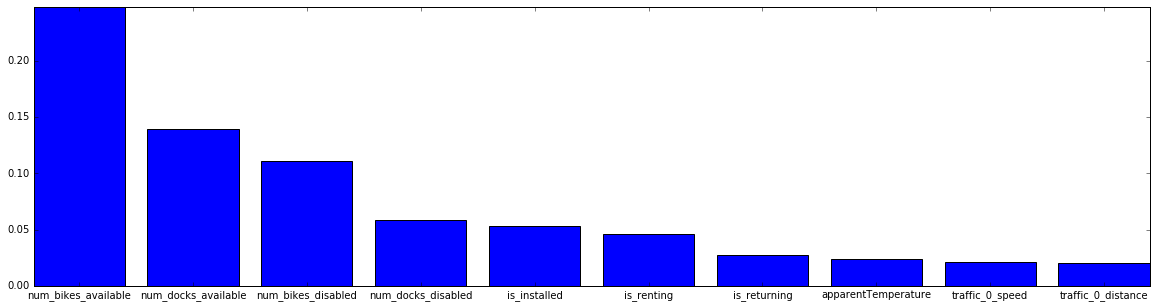

In [26]:
#most predictive features
features = list(x.columns)
feature_imp = clf.feature_importances_

top_features = pd.Series(data=feature_imp,index=features)
top_features.sort_values(inplace=True, ascending=False)

#plot
index = np.arange(0,10,1)
plt.figure(figsize=(20,5))
plt.bar(index,top_features[0:10], width = .8, align='center')
plt.xticks(index, features[0:10])
plt.axis('tight')

In [281]:
sklearn.metrics.roc_auc_score(test_df['target_60'],clf.predict_proba(test_df.drop('target_60', axis=1))[:,1])

ValueError: multiclass format is not supported